# Assignment 4
## Training a DNN for relation classification

In this assignment you are required to build a full training and testing pipeline for a neural relation classification (RC), using BERT.


**In this work we will use the hugingface framework for transformers training and inference.**
We recomand reading the documentation in [this](https://huggingface.co/docs/transformers/main/en/model_doc/bert#transformers.BertForSequenceClassification) link *before* you start coding.


All additional packages:

In [ ]:
# !pip install --q
!pip install --q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 57.1 MB/s eta 0:00:00


All imports: (You may add/change)

In [ ]:
# general
import os
import random
import warnings
from typing import List,Tuple
import math

# ML
from numba import cuda
import numpy as np
import scipy as sp
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix


# visual
import matplotlib
import seaborn as sns
from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
from IPython.display import display

# DL
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset

# HF
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import AutoTokenizer, AutoModel, AutoConfig

Set warnings filter to ignore:

In [ ]:
warnings.filterwarnings('ignore')

Set random SEEDs:

In [ ]:
SEED = 42

# Set the random seed for Python to SEED
random.seed(SEED)

# Set the random seed for numpy to SEED
np.random.seed(SEED)

# Set the random seed for torch to SEED
torch.manual_seed(SEED)

Set GPU:

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
assert DEVICE == 'cuda'

## Dataset


The dataset that you will be working on is called SemEval Task 8 dataset (https://arxiv.org/pdf/1911.10422v1.pdf).
The dataset contain only train and test split, but you are allowed to split the train dataset into dev if needed.


The two files (train and test) are available from the course git repository (https://github.com/kfirbar/nlp-course)

> Train file: `nlp-course/TRAIN_FILE.TXT`
> Test file: `nlp-course/TEST_FILE_FULL.TXT`


In [ ]:
!git clone https://github.com/kfirbar/nlp-course

Cloning into 'nlp-course'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 71 (delta 29), reused 40 (delta 11), pack-reused 0
Unpacking objects: 100% (71/71), 11.28 MiB | 3.11 MiB/s, done.


## Task #1

Write a funtion `read_data` for reading the data from a single file (either train or test).

<br>

This function recieves a filepath and returns a list of sentences; Every sentence is encoded as a tuple.

The first element is the sentence string.
The second element is the label (also represented as a sting).

In [ ]:
def read_data(filepath:str) -> List[Tuple[str,str]]:
    data = []
    with open(filepath, 'r') as f:
      lines = f.readlines()

    for record in split(lines, '\n'): # record is a list of a single sentence
      if len(record) == 0:
        continue

      sentence = record[0].split('\t')[1].strip('\r\n')
      label = record[1].strip('\r\n')

      data.append((sentence, label))

    return data


def split(sequence, sep):
    '''
    Generator function that gets a list and yields sub-lists by a given seperator.
    For example:
    [a, SEP, b, c, SEP, SEP, d] -> [[a], [b, c], [], [d]]
    '''
    chunk = []
    for val in sequence:
        if val == sep:
            yield chunk
            chunk = []
        else:
            chunk.append(val)
    yield chunk

train = read_data('nlp-course/TRAIN_FILE.TXT')
test = read_data('nlp-course/TEST_FILE_FULL.TXT')

print('Number of train sentences:', len(train))
print('Number of test sentences:', len(test))

Number of train sentences: 8000
Number of test sentences: 2717


`Pytorch` require the labels to be integers.

Create a mapper (dictionary) from the string labels to integers (starting zero).
And a dictionary from label to integer.

In [ ]:
def strip_label(label):
  return label.replace('(e1,e2)', '').replace('(e2,e1)', '')

def create_label_mapper(data, strip_labels=False):
  running_index = 0
  label2id = {}
  id2label = {}

  for _, label in data:
    stripped_label = strip_label(label) if strip_labels else label

    if stripped_label not in label2id:
      label2id[stripped_label] = running_index
      id2label[running_index] = stripped_label
      running_index += 1

  return id2label, label2id


id2label, label2id = create_label_mapper(train, True)

assert len(id2label) == len(label2id)
print('id2label: \n',id2label)

id2label: 
 {0: 'Component-Whole', 1: 'Other', 2: 'Instrument-Agency', 3: 'Member-Collection', 4: 'Cause-Effect', 5: 'Entity-Destination', 6: 'Content-Container', 7: 'Message-Topic', 8: 'Product-Producer', 9: 'Entity-Origin'}


<br>

Plot the distribution of labels in each dataset.
Display the information in a single plot.

For example:

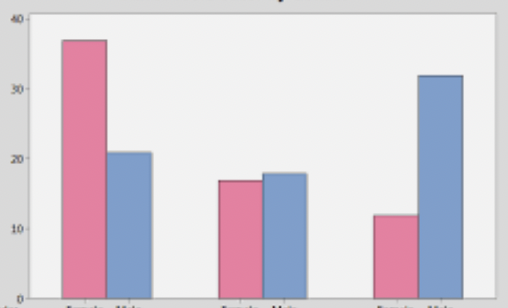

- Use bar plot.
- Use figuresize of (16,6).
- Add titles and Axis names.
- Y-axis will hold the count for each label.
- X-axis will hold the name of each label.

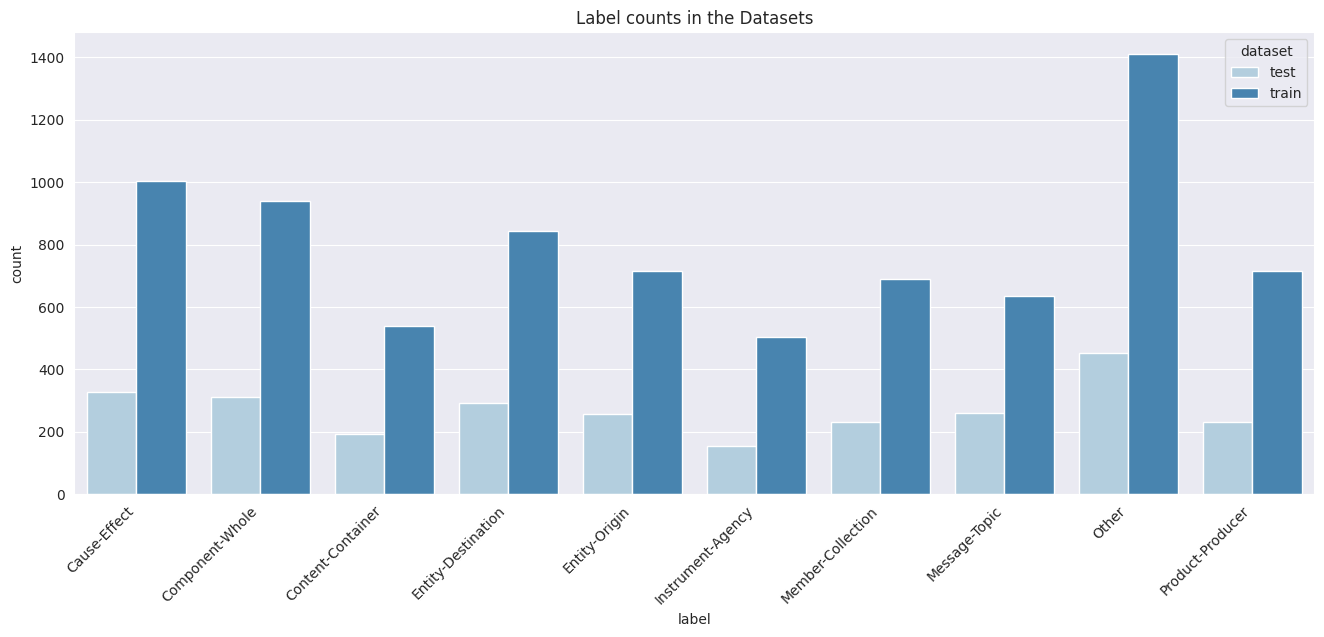

In [ ]:
train_df = pd.DataFrame(train, columns =['sentence', 'label'])
train_df['dataset'] = 'train'

test_df = pd.DataFrame(test, columns =['sentence', 'label'])
test_df['dataset'] = 'test'

unified_df = pd.concat([train_df, test_df])
unified_df['label'] = unified_df['label'].apply(strip_label)
unified_df = unified_df.groupby(['label', 'dataset']).size().reset_index(name='count')

plt.figure(figsize=(16,6))
sns.set_style('darkgrid')
sns.barplot(x='label', y='count', hue='dataset', data=unified_df, palette='Blues', edgecolor='w')

plt.title('Label counts in the Datasets')
plt.xticks(ha="right", rotation=45)
plt.show()

<br>

<br><br><br><br>


## Task #2

Download the relevant BERT tokenizer.
Use `bert-base-uncased` .


In [ ]:
# TO DO
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, timeout=3600.0)

Write a function `prepare_data` that takes one of the `train & test` datasets and convert each pair of `(words,labels)` to a pair of indexes.

The function also aggregate the samples into batches.

BERT Uses pretrained tokanization and embedding.
you can access the tokanization and indexing using the `BertTokenizer` class.

Note: you may use `torch.utils.data.Dataset`

In [ ]:
class BertDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        data, mask, label = self.sequences[idx]
        return data, mask, torch.tensor([label2id[strip_label(label)]])


def prepare_data(data, tokenizer, batch_size=32):
    data_sequences = [(tokenizer(sentence, max_length = 256, padding='max_length', return_tensors="pt"), label) \
                      for sentence, label in data]
    data_sequences = [(tokenized['input_ids'], tokenized['attention_mask'], label) \
                      for tokenized, label in data_sequences]

    return DataLoader(BertDataset(data_sequences), batch_size=batch_size)


train, val = train_test_split(train, test_size=0.1, random_state=42)
train_sequences = prepare_data(train, tokenizer)
val_sequences = prepare_data(val, tokenizer)
test_sequences = prepare_data(test, tokenizer)

<br><br><br><br>

## Task #3

In this part we classify the sentences using the `BertForSequenceClassification` model.


Download the relevant BERT model. Use `bert-base-uncased` .

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=10)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i


Write a function `get_parameters` that gets the model as an input and return the top(final) layer of the model for a `torch` optimizer.

Note: take a look at these links [link1](https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6#:~:text=%3E%3E%3E-,for%20name%2C%20para%20in%20net.named_parameters()%3A,-...%20%20%20%20%20para.requires_grad%20%3D%20False) [link2](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad_.html) .


In [ ]:
def get_parameters(params):
    top_layer_parameters = []

    for name, param in params:
      if "classifier" in name or "pooler" in name or "layer.11" in name:
        top_layer_parameters.append(param)
        param.requires_grad = True
      else:
        param.requires_grad = False

    return top_layer_parameters

all_model_params = model.named_parameters()
top_layer_params = get_parameters(all_model_params)

Define the optimizer:

- Use the `ADAM` optimizer (from `torch.optim`), which is a fancy version of SGD.
- Use a learning rate of 0.0001.
- Send only the top/final layer of the model to the optimizer (use `top_layer_params`).


In [ ]:
optimizer = Adam(top_layer_params, lr=0.0001)

## Task #4

Let's create the trainig function!


1. Write a training function, which takes a the model `BertForSequenceClassification` and number of epochs to train on.

2. Set `criterion` to the `CrossEntropyLoss` (from `torch.nn`) and use the `ADAM` optimizer.

3. Use a simple `for` loop to iterate over the epochs.
Use [tqdm](https://github.com/tqdm/tqdm) to mark your iteration and progress.

Notes:
- You may to split the `train` to `train&dev` sets.
- You may change the input/output of the training function.


In [ ]:
def training(model, n_epochs, train_data, dev_data=None, optimizer=None, criterion=None):

  if criterion is None:
    criterion = nn.CrossEntropyLoss()

  if optimizer is None:
    optimizer = Adam(model.parameters(), lr=0.0001)

  model.to(DEVICE)

  for epoch in tqdm(range(n_epochs)):
      train_loss = 0.0
      model.train()
      for data, mask, labels in train_data:
          data, mask, labels = data.squeeze(1).to(DEVICE), mask.squeeze(1).to(DEVICE), labels.squeeze(1).to(DEVICE)
          model.zero_grad()
          target = model(data, mask)['logits']
          loss = criterion(target, labels)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()

  return model

## Task #5

Write an evaluation loop on a trained model, using the test dataset.

Instructions:
> Input: model, data
> Output: Report, Confusion matrix

> 1. Display: Report, Confusion matrix
> 2. Save: a csv report


Explanation:
This function will perform an evaluation over a model with a dataset.
Calculate the `PERCISION, RECALL, F1` scores of each label seperately, and display them in a table.

Display a confusion matrix plot: where the predicted labels are the rows, and the true labels are the columns.


In addition, load thwe report to a dataframe and save to a CSV with this name:

> `{student_id_1}_{student_id_n}_part5.csv`
For example: `300123123_200456789_part_5.csv`



In [ ]:
cols   = ['PERCISION','RECALL','F1','SUPPORT']
labels = ['Other', 'Cause-Effect', 'Component-Whole', 'Content-Container', 'Entity-Destination', 'Entity-Origin', 'Instrument-Agency', 'Member-Collection', 'Message-Topic', 'Product-Producer']


def evaluate(model, test_data, label2id=label2id, id2label=id2label):
  model.eval()
  predict_label_l ,true_label_l = torch.tensor([]).to(DEVICE), torch.tensor([]).to(DEVICE)

  for data, mask, labels in test_data:
    data, mask, labels = data.squeeze(1).to(DEVICE), mask.squeeze(1).to(DEVICE), labels.squeeze(1).to(DEVICE)
    model.zero_grad()
    with torch.no_grad():
      logits = model(data, mask)['logits']
      predict_label_l = torch.cat((predict_label_l, torch.argmax(logits, axis=1)))
      true_label_l = torch.cat((true_label_l, labels))

  true_label_l = true_label_l.cpu().numpy()
  predict_label_l = predict_label_l.cpu().numpy()

  cm = confusion_matrix(true_label_l, predict_label_l)

  fig, ax = plt.subplots(1,1,figsize=(8,6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=label2id, yticklabels=label2id)
  plt.ylabel('Actual Category')
  plt.xlabel('Predicted Category')

  plt.title('Confusion matrix')

  plt.show()


  report = classification_report(true_label_l, predict_label_l, output_dict=True)
  df = pd.DataFrame(report).transpose()

  for k, v in id2label.items():
    df.rename(index={str(float(k)): v},inplace=True)
  print(tabulate(df, headers='keys', tablefmt='psql',floatfmt=".4f"))

  return df

In [ ]:
model = training(model, 40, train_data=train_sequences, optimizer=optimizer)

100%|██████████| 40/40 [1:25:27<00:00, 128.20s/it]


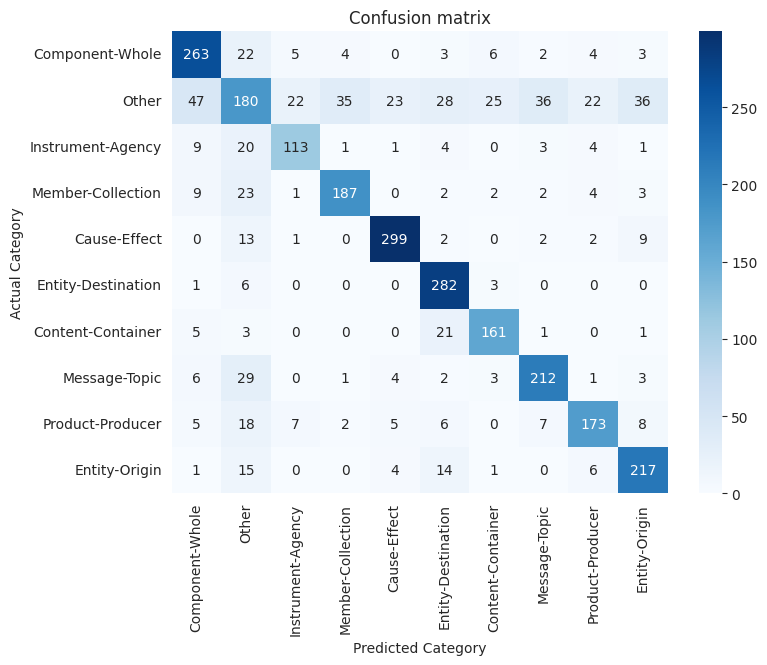

+--------------------+-------------+----------+------------+-----------+
|                    |   precision |   recall |   f1-score |   support |
|--------------------+-------------+----------+------------+-----------|
| Component-Whole    |      0.7601 |   0.8429 |     0.7994 |  312.0000 |
| Other              |      0.5471 |   0.3965 |     0.4598 |  454.0000 |
| Instrument-Agency  |      0.7584 |   0.7244 |     0.7410 |  156.0000 |
| Member-Collection  |      0.8130 |   0.8026 |     0.8078 |  233.0000 |
| Cause-Effect       |      0.8899 |   0.9116 |     0.9006 |  328.0000 |
| Entity-Destination |      0.7747 |   0.9658 |     0.8598 |  292.0000 |
| Content-Container  |      0.8010 |   0.8385 |     0.8193 |  192.0000 |
| Message-Topic      |      0.8000 |   0.8123 |     0.8061 |  261.0000 |
| Product-Producer   |      0.8009 |   0.7489 |     0.7740 |  231.0000 |
| Entity-Origin      |      0.7722 |   0.8411 |     0.8052 |  258.0000 |
| accuracy           |      0.7681 |   0.7681 |    

In [ ]:
df = evaluate(model.to(DEVICE), test_sequences)

In [ ]:
df.to_csv('319122610_206446221_part5.csv')

## Task #6

In this part we'll improve the model accuracy by using a method called "entity markers - Entity start".

The main idea of this approch is to add special markers ([e1], [\e1], ...) before and after each of the tagged entities. Instead of using the `CLS token` for clasification, we will use the concatination of the embedding of `[e1]` and `[e2]` as shown in the image below.

The complete method is described in details in the paper [Matching the Blanks: Distributional Similarity for Relation Learning following](https://arxiv.org/pdf/1906.03158.pdf) (specifically in Section 3.2).

 To use this method we'll need to create a new data load and a new model.

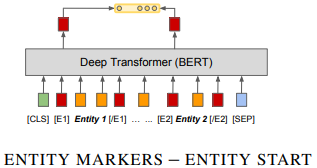

The new methods require the usage of special tokens.
Fix the following code so it will add the required tokens:

In [ ]:
E1_START = '<e1>'
E1_END   = '</e1>'
E2_START = '<e2>'
E2_END   = '</e2>'

new_tokens = [E1_START, E1_END, E2_START, E2_END]
mtb_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', timeout=3600.0, do_lower_case=True)
mtb_tokenizer.add_tokens(new_tokens)
MTB_id2label, MTB_label2id = create_label_mapper(train)

Create a new dataloader that add entity markers to the dataset and return their indexes as part of the new sample (the expected sample should be (s, l, i) where s is the sentence embedding, l is the label, and i is a touple with the indexes of the start entities)

Note: you may change the classes, function, etc.

In [ ]:
class MTBRCDataset(Dataset):
  def __init__(self, sequences):
    self.sequences = sequences

  def __len__(self):
      return len(self.sequences)

  def __getitem__(self, idx):
      data, mask, label, markers = self.sequences[idx]
      return data, mask, torch.tensor([MTB_label2id[label]]), markers


In [ ]:
def prepare_data_MTB(data, tokenizer, batch_size=32):
  result = []
  start = 0
  number_of_batches = math.ceil(len(data) / batch_size)
  e1, e2 = tokenizer.added_tokens_encoder['<e1>'], tokenizer.added_tokens_encoder['<e2>']

  for batch in range(number_of_batches):
    sentences, labels = [], []
    end = min(len(data), start + batch_size)

    for sentence, label in data[start:end]:
      sentences.append(sentence)
      labels.append(MTB_label2id[label])
    tokenized = tokenizer(sentences, max_length = 256, padding='max_length', return_tensors="pt", add_special_tokens=True)
    ids, mask = tokenized['input_ids'], tokenized['attention_mask']
    result.append(((ids, mask), labels, ((ids == e1).nonzero()[:,1], (ids == e2).nonzero()[:,1])))
    start += batch_size
  return result

mtb_train_dl = prepare_data_MTB(train, mtb_tokenizer)
mtb_test_dl = prepare_data_MTB(test, mtb_tokenizer)
mtb_dev_dl = prepare_data_MTB(val, mtb_tokenizer)

In [ ]:
# this is the dataloader length! the dataset length is the dl_length times batch size
print(len(mtb_train_dl),len(mtb_dev_dl),len(mtb_test_dl))

225 25 85


Create a new model that uses the "entity markers - Entity start" method.

In [ ]:
class MTB(nn.Module):
  def __init__(self, base_model_name):
    super(MTB, self).__init__()
    config = AutoConfig.from_pretrained(base_model_name, num_labels=len(MTB_label2id))
    config.num_labels = len(MTB_label2id)

    self.bert = AutoModel.from_pretrained(base_model_name, config=config)
    self.bert.resize_token_embeddings(len(mtb_tokenizer))
    self.num_labels = config.num_labels
    self.hidden_size = config.hidden_size
    self.classifier = nn.Linear(self.hidden_size * 2, self.num_labels)

  def forward(self, values, index):
      (ids, mask) = values
      e1, e2 = torch.tensor(index[0]).unsqueeze(-1), torch.tensor(index[1]).unsqueeze(-1)
      hidden = self.bert(ids, attention_mask=mask, output_hidden_states=True).hidden_states[12].to(DEVICE)
      e1_index, e2_index = (e1.repeat(1,self.hidden_size).to(DEVICE)).unsqueeze(1), (e2.repeat(1,self.hidden_size).to(DEVICE)).unsqueeze(1)
      hidden_states = torch.cat((torch.squeeze(torch.gather(hidden, 1, e1_index), dim=1),  torch.squeeze(torch.gather(hidden, 1, e2_index),dim=1)), dim=1)
      return self.classifier(hidden_states)

mtb_model = MTB('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Use the new dataloader and model to train the new model as in task 4.



**Evaluation**

Use the new dataloader and model to evaluate the new model as in task 5.
> 1. Display: Report, Confusion matrix
> 2. Save: a csv report

Use this format:
> `{student_id_1}_{student_id_n}_part6.csv`
> For example: `300123123_200456789_part_6.csv`


In [ ]:
def training_mtb(model, n_epochs, train_data, dev_data=None, optimizer=None, criterion=None):

  if criterion is None:
    criterion = nn.CrossEntropyLoss()

  if optimizer is None:
    optimizer = Adam(get_parameters(model.named_parameters()), lr=0.0001)

  model.to(DEVICE)

  for epoch in tqdm(range(n_epochs)):
      train_loss = 0.0
      model.train()
      for (data, mask), labels, token_ids in train_data:
          data, mask, labels = data.to(DEVICE), mask.to(DEVICE), torch.tensor(labels).to(DEVICE)
          model.zero_grad()
          target = model((data, mask), token_ids)
          loss = criterion(target, labels)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()

  return model


def evaluate_mtb(model, test_data, label2id=label2id, id2label=id2label):
  model.eval()
  predict_label_l ,true_label_l = torch.tensor([]).to(DEVICE), torch.tensor([]).to(DEVICE)

  for (data, mask), labels, token_ids in test_data:
    data, mask, labels = data.to(DEVICE), mask.to(DEVICE), torch.tensor(labels).to(DEVICE)
    model.zero_grad()
    with torch.no_grad():
      logits = torch.log_softmax(model((data, mask), token_ids), dim=1)
      predict_label_l = torch.cat((predict_label_l, torch.argmax(logits, axis=1)))
      true_label_l = torch.cat((true_label_l, labels))

  true_label_l = true_label_l.cpu().numpy()
  predict_label_l = predict_label_l.cpu().numpy()

  cm = confusion_matrix(true_label_l, predict_label_l)

  fig, ax = plt.subplots(1,1,figsize=(8,6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=label2id, yticklabels=label2id)
  plt.ylabel('Actual Category')
  plt.xlabel('Predicted Category')

  plt.title('Confusion matrix')

  plt.show()


  report = classification_report(true_label_l, predict_label_l, output_dict=True)
  df = pd.DataFrame(report).transpose()

  for k, v in id2label.items():
    df.rename(index={str(float(k)): v},inplace=True)
  print(tabulate(df, headers='keys', tablefmt='psql',floatfmt=".4f"))

  return df



100%|██████████| 40/40 [1:25:17<00:00, 127.94s/it]


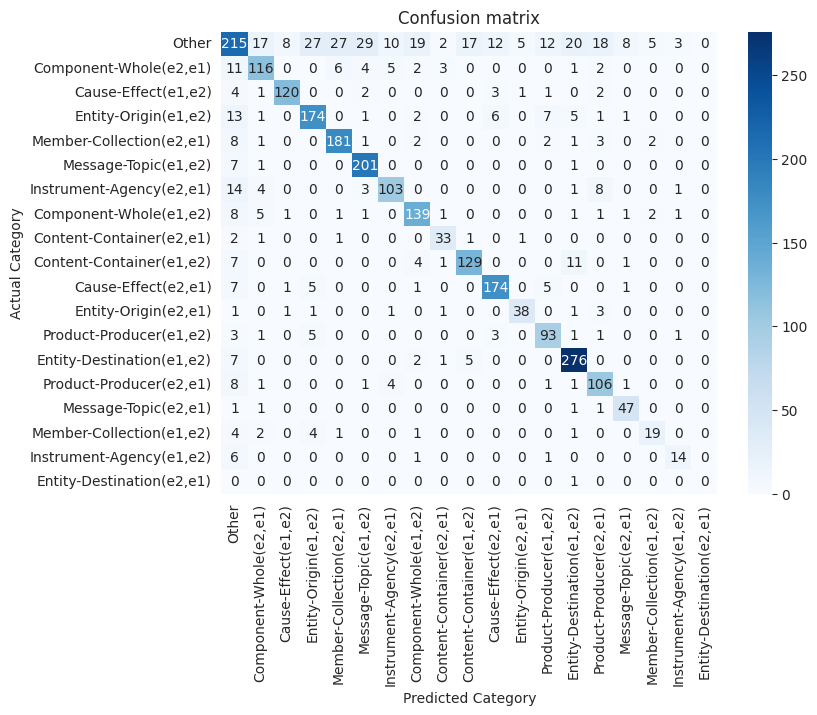

+---------------------------+-------------+----------+------------+-----------+
|                           |   precision |   recall |   f1-score |   support |
|---------------------------+-------------+----------+------------+-----------|
| Other                     |      0.6595 |   0.4736 |     0.5513 |  454.0000 |
| Component-Whole(e2,e1)    |      0.7632 |   0.7733 |     0.7682 |  150.0000 |
| Cause-Effect(e1,e2)       |      0.9160 |   0.8955 |     0.9057 |  134.0000 |
| Entity-Origin(e1,e2)      |      0.8056 |   0.8246 |     0.8150 |  211.0000 |
| Member-Collection(e2,e1)  |      0.8341 |   0.9005 |     0.8660 |  201.0000 |
| Message-Topic(e1,e2)      |      0.8272 |   0.9571 |     0.8874 |  210.0000 |
| Instrument-Agency(e2,e1)  |      0.8374 |   0.7687 |     0.8016 |  134.0000 |
| Component-Whole(e1,e2)    |      0.8035 |   0.8580 |     0.8299 |  162.0000 |
| Content-Container(e2,e1)  |      0.7857 |   0.8462 |     0.8148 |   39.0000 |
| Content-Container(e1,e2)  |      0.848

In [ ]:
mtb_model = training_mtb(mtb_model, 40, mtb_train_dl, mtb_dev_dl)
df_mtb = evaluate_mtb(mtb_model, mtb_test_dl, label2id=MTB_label2id, id2label=MTB_id2label)

In [ ]:
df_mtb.to_csv('319122610_206446221_part6.csv')

<br><br><br><br><br>

## Task 7

In  this final task we will classify similar sentences (1 - similar, 0 - not similar).
We will use an `off the shelf model` and run inference.

- Get the kaggle dataset and create a inference pipeline for the Sentence similarity. Use an off-the-shelf.

Note: you may add change cells as you pleased.


Optional: Clear GPU space if needed

In [ ]:
import gc

gc.collect()

device = cuda.get_current_device()
device.reset()

Set all the relavant random seed to 111

In [ ]:
SEED = 111

# Set the random seed for Python to SEED
random.seed(SEED)

# Set the random seed for numpy to SEED
np.random.seed(SEED)

# Set the random seed for torch to SEED
torch.manual_seed(SEED)

Download the `train` dataset from [here](https://github.com/saharmilis/runi-nlp/tree/main/kaggle).

In [ ]:
!git clone https://github.com/saharmilis/runi-nlp/

Cloning into 'runi-nlp'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 23 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (23/23), 3.61 MiB | 3.20 MiB/s, done.


Download the sentence similarty tokenizer & model `all-mpnet-base-v2`.
Here the [link](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) to the model.



In [ ]:
import torch.nn.functional as F

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

mpnet_tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
mpnet_model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')
cos = torch.nn.CosineSimilarity(dim=0)

def get_similarity_score(s1, s2):
  encoded_input = mpnet_tokenizer([s1, s2], padding=True, truncation=True, return_tensors='pt')

  with torch.no_grad():
      model_output = mpnet_model(**encoded_input)

  # Perform pooling
  sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

  return int(cos(sentence_embeddings[0], sentence_embeddings[1]).item() + 0.5)


Run inference on the **first 5K lines** in the train dataset, and save it in a dataframe.

In [ ]:
df_t7 = pd.DataFrame(columns=['ID','LABEL_TRUE','LABEL_PRED'])

df_sim = pd.read_csv('runi-nlp/kaggle/nlp_2023_train.csv', header=0, names=['ID','text1','text2', 'Similarity']).head(5000)
df_t7['LABEL_PRED'] = df_sim.apply(lambda x: get_similarity_score(s1=x['text1'], s2=x['text2']), axis=1)
df_t7['ID'] = df_sim['ID']
df_t7['LABEL_TRUE'] = df_sim['Similarity'].apply(lambda x: int(x + 0.5))

Print a classification report (use a simple SK-learn classification report)

Save a CSV file as `{student_id_1}_{student_id_n}_part7.csv` with this format: `ID, LABEL_TRUE, LABEL_PRED`

Notice:
- Do not write the index number to the CSV file.
- Make sure the CSV file will contain only integers.


In [ ]:
df_t7.to_csv('319122610_206446221_part7.csv', index=False)

print(classification_report(df_t7['LABEL_TRUE'], df_t7['LABEL_PRED']))

              precision    recall  f1-score   support

           0       1.00      0.40      0.57      3114
           1       0.50      1.00      0.67      1886

    accuracy                           0.62      5000
   macro avg       0.75      0.70      0.62      5000
weighted avg       0.81      0.62      0.61      5000



<br><br><br><br><br><br>
**Good luck!**